In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import jaxley as jx
from jaxley_retina.mnist import simple_data_prep, model, image_to_stim

2025-11-06 16:01:56.612122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762441316.653754   52354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762441316.666821   52354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762441316.701619   52354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762441316.701691   52354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762441316.701697   52354 computation_placer.cc:177] computation placer alr

In [2]:
# Configurations for training the model without distortions
model_config = {
    'BC_readouts': True,
    'use_benison': True, # added later
    'connections': 'local',
    'nHCs': 9,
    'nPRs': 200,
    'n_rad': 50,
    'n_readouts': 10,
    'ptc_path': '../../params/cascade/params_3.pkl',
    'ribbon_path': '../../params/ribbon/best_20_params.pkl'
}

stim_config = {
    'digits': 'all',
    'dt': 0.025,
    'outer_ramp_up': 1000,
    'peak_end': 50,
    'peak_start': 0,
    'stim_max': 40000,
    't_max': 200,
    'test_contrast_max': 1.0,
    'test_contrast_min': 1.0,
    'test_lum_max': 0.0,
    'test_lum_min': 0.0,
    'train_contrast_max': 1.0,
    'train_contrast_min': 1.0,
    'train_lum_max': 0.0,
    'train_lum_min': 0.0
}

train_config = {
    'IonotropicSynapse_gS_init': 'normal',
    'IonotropicSynapse_gS_init_mean': 0.01,
    'IonotropicSynapse_gS_init_std': 0.001,
    'IonotropicSynapse_gS_lower': -20,
    'IonotropicSynapse_gS_upper': -3,
    'RibbonHC_gS_init': 'normal',
    'RibbonHC_gS_init_mean': 1.0e-07,
    'RibbonHC_gS_init_std': 1.0e-08,
    'RibbonHC_gS_lower': -25,
    'RibbonHC_gS_upper': -5,
    'RibbonReadout_gS_init': 'normal',
    'RibbonReadout_gS_init_mean': 1.0e-06,
    'RibbonReadout_gS_init_std': 1.0e-07,
    'RibbonReadout_gS_lower': -25,
    'RibbonReadout_gS_upper': -5,
    'batch_size': 32,
    'checkpoint_lengths': [20, 20, 20],
    'decay_rate': 0.9,
    'loss_start': 0,
    'max_epochs': 5,
    'seed': 0,
    'start_lr': 0.01,
    'stop_criteria': 0.995,
    'transition_steps': 1000,
}

In [3]:
# Build the model for indexing and such
_ = np.random.seed(train_config['seed'])
network = model.build_mnist_model(model_config)

network.PR.compute_compartment_centers()
coords = np.vstack((network.PR.nodes.x, network.PR.nodes.y))
coords.shape

(2, 200)

In [4]:
# Set up the parameter training
network.delete_trainables()
network, transform = model.setup_param_training(network, train_config)

Number of newly added trainable parameters: 2000. Total number of trainable parameters: 2000
Number of newly added trainable parameters: 450. Total number of trainable parameters: 2450
Number of newly added trainable parameters: 450. Total number of trainable parameters: 2900


In [5]:
# Do the ramp-up for the network and save the states
PR_inds = network.PR.nodes.global_cell_index.tolist()
ramp_up_time = np.arange(0, stim_config["outer_ramp_up"], stim_config["dt"])
ramp_up_stim = np.zeros((len(PR_inds), len(ramp_up_time)))

params = network.get_parameters()

network.record(verbose=False) # Recordings will change below

data_clamps = network.cell(PR_inds).data_clamp("PR_Phototransduction_Stim", ramp_up_stim, None)
init_soln, init_states = jx.integrate(
    network,
    delta_t=stim_config["dt"],
    data_clamps=data_clamps,
    params=params, 
    return_states=True
)

In [6]:
if isinstance(train_config["checkpoint_lengths"], int):
    assert(train_config["checkpoint_lengths"] > 0), "Checkpoint lengths must be > 0"
    levels = train_config["checkpoint_lengths"]
    num_timesteps = int(stim_config["t_max"] / stim_config["dt"])
    checkpoints = [int(np.ceil(num_timesteps ** (1/levels))) for _ in range(levels)]
else:
    checkpoints = train_config["checkpoint_lengths"]

def simulate(params, stim):
    data_clamps = network.cell(PR_inds).data_clamp("PR_Phototransduction_Stim", stim, None)
    soln = jx.integrate(
        network, 
        delta_t=stim_config["dt"],
        data_clamps=data_clamps,
        params=params,
        all_states=init_states,
        checkpoint_lengths=checkpoints
    )
    return soln[:, :-1]

In [7]:
# Load the trained parameters 
with open("../../params/mnist/trained_params_0504_209_full.pkl", "rb") as file:
    trained_params = pickle.load(file)

### Glutamate release only

In [8]:
# Recordings
network.delete_recordings()
network.RibbonHC.record("RibbonHC_exo") # Before Jaxley PR #643, when recording RibbonReadout_exo wasn't possible

Added 450 recordings. See `.recordings` for details.


In [9]:
# The stimulus at each of the different min contrasts
levels = np.arange(0, 1.01, step=0.1)
activities = []

for l in tqdm(levels):
    ds_test, = simple_data_prep.build_train_loader(
        train_config["batch_size"], 
        digits=stim_config["digits"],
        contrast_range=(l, l),
        lum_range=(stim_config["test_lum_min"], stim_config["test_lum_max"]),
        splits=["test"],
    )
    imgs, labels = next(ds_test)
    stim = image_to_stim.stimulus_from_image(imgs[0], coords, stim_config)
    activity = simulate(trained_params, stim)
    activities.append(activity)

  0%|          | 0/11 [00:00<?, ?it/s]

2025-11-06 16:04:22.260773: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-06 16:04:38.496459: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-06 16:04:54.370672: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. I

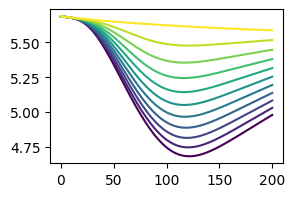

In [10]:
# Preliminary plot
fig = plt.figure(figsize=(3, 2))

time = np.arange(0, 200, 0.025)
colors = plt.cm.viridis(np.linspace(0, 1, num=len(levels)))

_, indices = np.unique(network.edges.pre_global_cell_index.to_numpy(), return_index=True)
for_plotting = np.random.choice(indices, 1, replace=False)

for i in range(len(levels)):
    for j in for_plotting:
        plt.plot(time, activities[i][j, :], color=colors[i])

In [11]:
with open(str("../../paper/fig4/results/fig4_coneact_209.pkl"), "wb") as f:
    pickle.dump((levels, activities), f)

### Averaging dynamics over all cones

In [12]:
# Set up the recordings
network.delete_recordings()
rec_vars = ["Stim", "R", "P", "G", "C", "I"]
for var in rec_vars:
    network.PR.record(f"PR_Phototransduction_{var}")
network.PR.record("v")
network.RibbonReadout.record("RibbonReadout_exo") # In rebuttal phase, after Jaxley PR #643
all_rec_vars = rec_vars + ["v", "glu"]
all_rec_vars

Added 200 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 200 recordings. See `.recordings` for details.
Added 2000 recordings. See `.recordings` for details.


['Stim', 'R', 'P', 'G', 'C', 'I', 'v', 'glu']

In [13]:
tstep = np.arange(0, 50, step=0.025).shape[0]
split_inds = [200] * np.arange(1, 8)
cell_inds, arr_inds = np.unique(network.RibbonReadout.edges.pre_index.to_numpy(), return_index=True)

In [14]:
test_contrasts = np.arange(0, 1.01 , step=0.1)
solns = {k: [] for k in all_rec_vars}

for c in tqdm(test_contrasts):
    # Rebuild the dataset
    ds_test, = simple_data_prep.build_train_loader(
        train_config["batch_size"], 
        digits=stim_config["digits"],
        contrast_range=(c, c),
        lum_range=(stim_config['test_lum_min'], stim_config['test_lum_max']),
        splits=["test"]
    )
    imgs, labels = next(ds_test)
    stim = image_to_stim.stimulus_from_image(imgs[0], coords, stim_config)
    print(f"Lab: {labels[0]}")
    # Run the simulation & save
    s = simulate(trained_params, stim)
    s = np.split(s, split_inds)
    s[-1] = s[-1][arr_inds, :]
    [solns[k].append(x) for k, x in zip(solns.keys(), s)]

  0%|          | 0/11 [00:00<?, ?it/s]

2025-11-06 16:07:04.659116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:07:22.573297: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:07:46.224396: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:08:05.602264: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:08:23.254673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:08:41.858760: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:09:04.187438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:09:23.377214: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:09:45.195185: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:10:02.839143: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:10:22.728017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


In [15]:
means = []
sems = []

for k in solns:
    soln_50ms = np.abs(np.array(solns[k])[:, :, tstep])
    avg_soln = np.abs(np.mean(np.array(solns[k]), axis=2))
    # Calculate the coefficient of variation for each cell
    cvs = np.std(avg_soln, axis=0)/np.mean(avg_soln, axis=0)
    # Get the mean and sem for each state variable
    means.append(np.mean(cvs))
    sems.append(np.std(cvs)/np.sqrt(cvs.shape[0]))

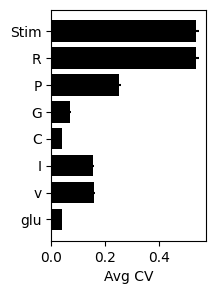

In [16]:
# Preliminary plot
fig = plt.figure(figsize=(2, 3))
plt.barh(np.flip(all_rec_vars), np.flip(means), xerr=np.flip(sems), color="k")
plt.xlabel("Avg CV")
plt.show()

In [17]:
# Save the results
with open("../../paper/fig4/results/state_var_solns.pkl", "wb") as f:
    pickle.dump({"vars": all_rec_vars, "means": means, "sems": sems}, f)

### States of a particular cone

In [18]:
# In distribution contrasts
contrast_range = (stim_config["train_contrast_min"], stim_config["train_contrast_max"])
lum_range = (stim_config["train_lum_min"], stim_config["train_lum_max"])
print(contrast_range)
print(lum_range)

ds_train, ds_test = simple_data_prep.build_train_loader(
    train_config["batch_size"], 
    digits=stim_config["digits"],
    contrast_range=contrast_range,
    lum_range=lum_range,
    splits=["train", "test"]
)

(1.0, 1.0)
(0.0, 0.0)


2025-11-06 16:10:50.333275: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


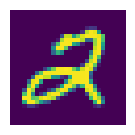

In [19]:
# Image used for choosing the PR location
imgs, labels = next(ds_test) 
fig, axs = plt.subplots(figsize=(1.5, 1.5))
axs.matshow(imgs[0], vmin=0, vmax=1)
axs.set_axis_off()

In [20]:
# Set up the recordings
network.delete_recordings()

# Choosing which PR
stim = image_to_stim.stimulus_from_image(imgs[0], coords, stim_config)
stim_pos = np.where(np.sum(stim, axis=1) > 0)[0]
random_pr = PR_inds[stim_pos[0]]

rec_vars = ["Stim", "R", "P", "G", "S", "C", "I"]
for var in rec_vars:
    network.cell(random_pr).record(f"PR_Phototransduction_{var}")
network.cell(random_pr).record("v")

# Note about setting recordings in Jaxley
# network.cell(random_pr).RibbonReadout.edges # empty
# network.cell(random_pr).edges # also empty
# network.RibbonHC.edges # not empty

# Can't yet record from just one edge, recording from this synapse group because there are fewer synapses
synapse_vars = ["exo", "RRP", "IP", "RP"]
for var in synapse_vars:
    network.RibbonReadout.record(f"RibbonReadout_{var}")

network.readout.record("v")

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 2000 recordings. See `.recordings` for details.
Added 2000 recordings. See `.recordings` for details.
Added 2000 recordings. See `.recordings` for details.
Added 2000 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.


In [21]:
soln_inds = rec_vars + ["pr_v"] + np.repeat(synapse_vars, len(network.RibbonReadout.edges)).tolist() + [f"readout{i}_v" for i in range(model_config["n_readouts"])]
all_rec_vars, save_inds = np.unique(soln_inds, return_index=True)

In [22]:
test_contrasts = np.arange(0, 1.01 , step=0.1)
solns = dict.fromkeys(test_contrasts)

for c in tqdm(test_contrasts):
    # Rebuild the dataset
    ds_test, = simple_data_prep.build_train_loader(
        train_config["batch_size"], 
        digits=stim_config["digits"],
        contrast_range=(c, c),
        lum_range=(stim_config['test_lum_min'], stim_config['test_lum_max']),
        splits=["test"]
    )
    imgs, labels = next(ds_test)
    stim = image_to_stim.stimulus_from_image(imgs[0], coords, stim_config)
    print(f"Lab: {labels[0]}")
    # Run the simulation & save
    s = simulate(trained_params, stim)[save_inds, :]
    solns[c] = s
    

  0%|          | 0/11 [00:00<?, ?it/s]

2025-11-06 16:10:53.609750: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:11:12.463222: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:11:36.334914: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:11:57.855709: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:12:22.811695: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:12:45.556809: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:13:08.579206: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:13:37.650387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:14:00.932071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:14:28.975446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


2025-11-06 16:14:54.162063: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Lab: 2


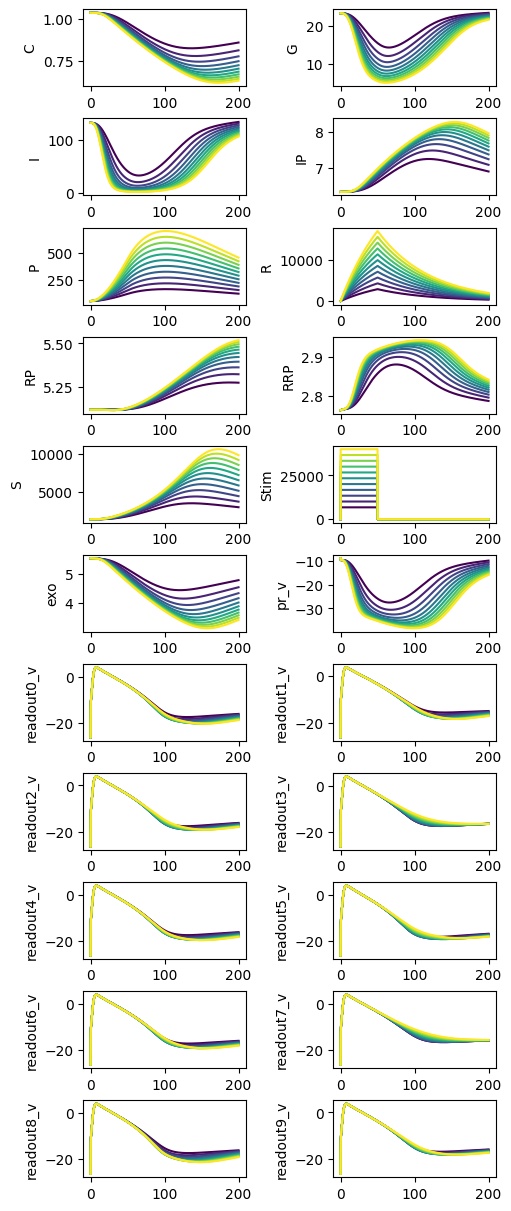

In [23]:
# Preliminary plot
fig, axs = plt.subplots(11, 2, layout="constrained", figsize=(5, 12))

time = np.arange(0, stim_config["t_max"], stim_config["dt"])

colors = plt.cm.viridis(np.linspace(0, 1, num=len(solns)))

for i, key in enumerate(solns):
    for j in range(solns[key].shape[0]):
        axs.flat[j].plot(time, solns[key][j, :], color=colors[i])
        axs.flat[j].set_ylabel(all_rec_vars[j])


In [24]:
# Save all the solutions
with open("../../paper/fig4/results/all_state_vars.pkl", "wb") as f:
    pickle.dump({
        "solns": solns,
        "rec_vars": all_rec_vars,
        "contrast_levels": test_contrasts
    }, f)